## Import Library

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

## Read data

In [58]:
data = pd.read_csv('VIC.csv')

print(data.shape)
print(data.sample(7))

(101266, 8)
      Ticker         Date/Time   Open   High    Low  Close  Volume  \
76833    VIC     7/2/2020 9:34   90.3   90.3   90.3   90.3     250   
81680    VIC    8/5/2020 13:29   88.0   88.0   88.0   88.0      10   
10128    VIC     1/9/2019 9:34  101.4  101.4  100.1  100.1     830   
77325    VIC    7/6/2020 11:24   91.4   91.4   90.6   90.6      50   
9184     VIC  12/28/2018 10:41  102.5  102.8  102.5  102.8      20   
60892    VIC   3/11/2020 11:06   96.4   96.5   96.4   96.4    2980   
17802    VIC   3/15/2019 10:14  118.8  118.8  118.7  118.8     220   

       Open Interest  
76833              0  
81680              0  
10128              0  
77325              0  
9184               0  
60892              0  
17802              0  


## Preprocessing data

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         101266 non-null  object 
 1   Date/Time      101266 non-null  object 
 2   Open           101266 non-null  float64
 3   High           101266 non-null  float64
 4   Low            101266 non-null  float64
 5   Close          101266 non-null  float64
 6   Volume         101266 non-null  int64  
 7   Open Interest  101266 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 6.2+ MB


Conver Dtype Column['Date/Time'] from object to datetime 

In [60]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         101266 non-null  object        
 1   Date/Time      101266 non-null  datetime64[ns]
 2   Open           101266 non-null  float64       
 3   High           101266 non-null  float64       
 4   Low            101266 non-null  float64       
 5   Close          101266 non-null  float64       
 6   Volume         101266 non-null  int64         
 7   Open Interest  101266 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 6.2+ MB


Delete Column['Open Interest']

In [61]:
data = data.drop(['Open Interest'], axis=1)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     101266 non-null  object        
 1   Date/Time  101266 non-null  datetime64[ns]
 2   Open       101266 non-null  float64       
 3   High       101266 non-null  float64       
 4   Low        101266 non-null  float64       
 5   Close      101266 non-null  float64       
 6   Volume     101266 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.4+ MB


In [63]:
data.isnull().sum()

Ticker       0
Date/Time    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

This implies that there are no null values in the data set provided.



## Data Analyst



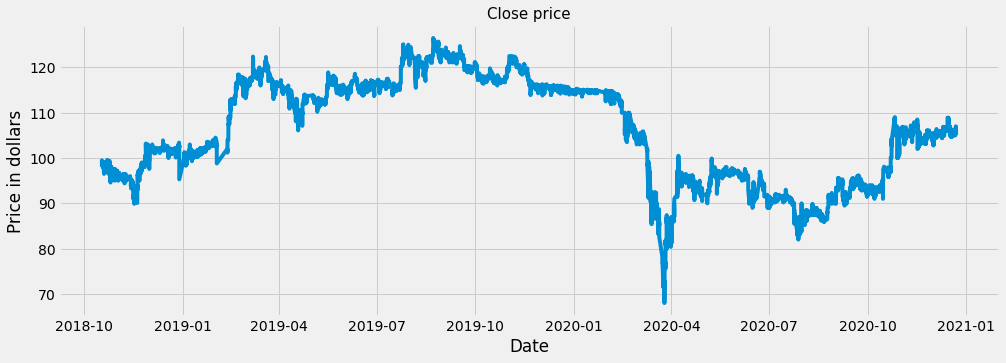

In [64]:
plt.figure(figsize=(15,5))
plt.plot(data['Date/Time'], data['Close'])
plt.title('Close price', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price in dollars')
plt.show()

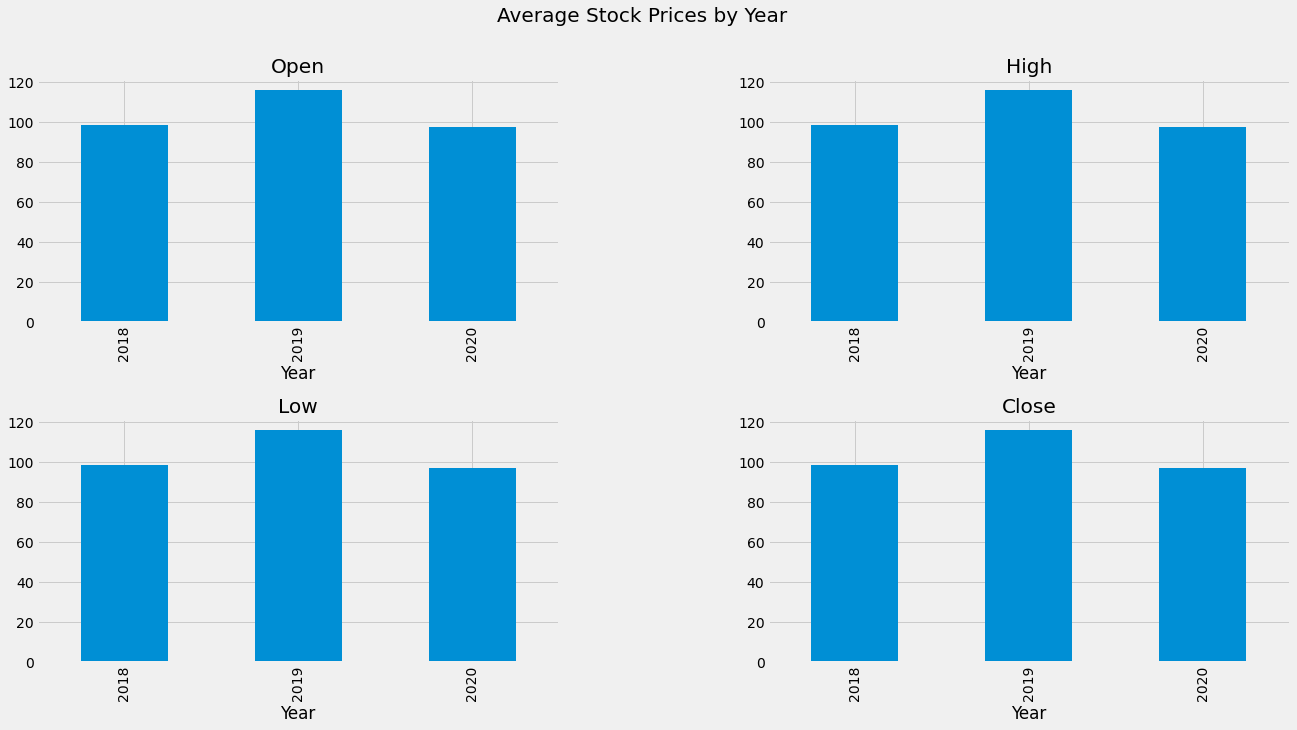

In [65]:
data['Year'] = data['Date/Time'].dt.year
data_grouped = data.groupby('Year').mean()

plt.subplots(figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i+1)
    data_grouped[col].plot.bar()
    plt.title(col)
    plt.suptitle('Average Stock Prices by Year', fontsize=20)
    
plt.show()

## Create training and test dataset

In [66]:
dataset = data['Close'].values
training = int(np.ceil(len(dataset) * .95))
print(training)

96203


In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset.reshape(-1, 1)
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Build Gated LSTM network using Keras

In [68]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f37363f9f70>>

## Model Compilation and Training

In [69]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=1)


3005/3005 [==============================] - 258s 84ms/step - loss: 0.0058


### Save model

In [70]:
model.save('lstm_model.h5')

In [85]:
# model = load_model('lstm_model.h5')

In [86]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Predict the testing data

In [87]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

159/159 [==============================] - 4s 22ms/step


### Evaluation metrics

`mse = np.mean(((predictions - y_test) ** 2))`: This calculates the mean squared error (MSE) between the predicted values and the true values.



In [88]:
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)

MSE 0.02576879783223384


`print("MSE", mse) and print("RMSE", np.sqrt(mse))`: These print the MSE and the root mean squared error (RMSE) of the predictions, respectively.

In [89]:
print("RMSE", np.sqrt(mse))

RMSE 0.16052662655221359


## Results

### Visualize the final results

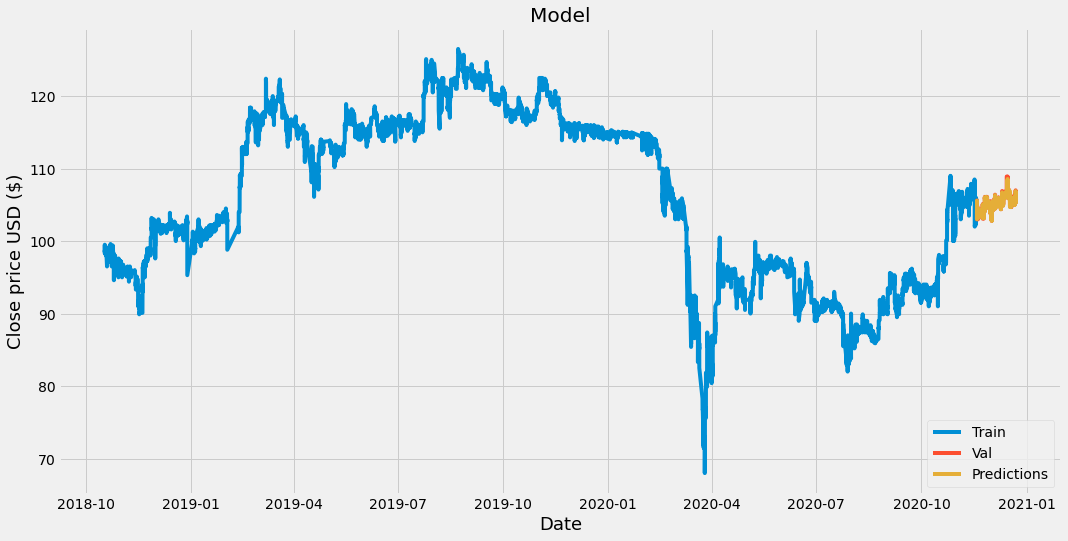

In [90]:
train = data[:training]
valid = data[training:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.plot(train['Date/Time'], train['Close'])
plt.plot(valid['Date/Time'], valid['Close'])
plt.plot(valid['Date/Time'], valid['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [91]:
new_df = data.filter(['Close'])

In [92]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Year,Predictions
96203,VIC,2020-11-18 13:11:00,103.8,103.9,103.8,103.9,3760,2020,103.789467
96204,VIC,2020-11-18 13:12:00,103.9,103.9,103.9,103.9,10,2020,103.878128
96205,VIC,2020-11-18 13:13:00,103.9,103.9,103.5,103.5,1910,2020,103.907547
96206,VIC,2020-11-18 13:14:00,103.5,103.7,103.2,103.2,11610,2020,103.646584
96207,VIC,2020-11-18 13:15:00,103.1,103.4,103.1,103.4,7220,2020,103.338478
...,...,...,...,...,...,...,...,...,...
101261,VIC,2020-12-22 14:22:00,105.8,105.8,105.7,105.7,1870,2020,105.740517
101262,VIC,2020-12-22 14:23:00,105.7,105.7,105.7,105.7,2510,2020,105.674965
101263,VIC,2020-12-22 14:24:00,105.7,105.7,105.7,105.7,3620,2020,105.649178
101264,VIC,2020-12-22 14:25:00,105.7,105.7,105.7,105.7,100,2020,105.642815


In [93]:
valid['Change'] = valid['Predictions'] - valid['Close'].shift()

In [94]:
valid

,Ticker,Date/Time,Open,High,Low,Close,Volume,Year,Predictions,Change
96203,VIC,2020-11-18 13:11:00,103.8,103.9,103.8,103.9,3760,2020,103.789467,NaN
96204,VIC,2020-11-18 13:12:00,103.9,103.9,103.9,103.9,10,2020,103.878128,-0.021872
96205,VIC,2020-11-18 13:13:00,103.9,103.9,103.5,103.5,1910,2020,103.907547,0.007547
96206,VIC,2020-11-18 13:14:00,103.5,103.7,103.2,103.2,11610,2020,103.646584,0.146584
96207,VIC,2020-11-18 13:15:00,103.1,103.4,103.1,103.4,7220,2020,103.338478,0.138478
...,...,...,...,...,...,...,...,...,...,...
101261,VIC,2020-12-22 14:22:00,105.8,105.8,105.7,105.7,1870,2020,105.740517,-0.059483
101262,VIC,2020-12-22 14:23:00,105.7,105.7,105.7,105.7,2510,2020,105.674965,-0.025035
101263,VIC,2020-12-22 14:24:00,105.7,105.7,105.7,105.7,3620,2020,105.649178,-0.050822
101264,VIC,2020-12-22 14:25:00,105.7,105.7,105.7,105.7,100,2020,105.642815,-0.057185


This function uses the LSTM model trained on historical stock price data to predict future stock prices. It takes in the following parameters:

* `data`: a Pandas DataFrame containing the historical stock price data

* `time_frame`: a string indicating the time frame for the prediction, which can be one of 'hour', 'day', 'week', or 'month'

* `num_units`: an integer indicating the number of time units to predict into the future

In [95]:
def predict_stock_price(data, time_frame, num_units):
    new_df = data.filter(['Close'])
    last_num_days = {'hour': 24, 'day': 60, 'week': 7*60, 'month': 30*60}[time_frame]
    last_prices = new_df[-last_num_days:].values
    last_prices_reshaped = last_prices.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    last_prices_scaled = scaler.fit_transform(last_prices_reshaped)
    last_prices_scaled_reshaped = last_prices_scaled.reshape(1, -1, 1)
    model = load_model('lstm_model.h5')
    predicted_prices = []
    latest_price = data.loc[data['Date/Time'].idxmax(), 'Close']
    for i in range(num_units):
        if i == 0:
            predicted_price = model.predict(last_prices_scaled_reshaped)
        else:
            last_prices = np.append(last_prices[1:], predicted_price)
            last_prices_reshaped = last_prices.reshape(-1, 1)
            last_prices_scaled = scaler.transform(last_prices_reshaped)
            last_prices_scaled_reshaped = last_prices_scaled.reshape(1, -1, 1)
            predicted_price = model.predict(last_prices_scaled_reshaped)
        predicted_price = scaler.inverse_transform(predicted_price)
        target_date = data['Date/Time'].max().date() + timedelta(**{time_frame + 's': i+1})
        change = predicted_price[0][0] - latest_price
        predicted_prices.append({'Date': target_date, 'Price': predicted_price[0][0], 'Change': change})
    return pd.DataFrame(predicted_prices)


In [96]:
predicted_prices = predict_stock_price(data, time_frame='day', num_units=15)

1/1 [==============================] - 0s 36ms/step


In [97]:
print(predicted_prices)

          Date       Price    Change
0   2020-12-23  105.697426 -0.002574
1   2020-12-24  105.696785 -0.003215
2   2020-12-25  105.696411 -0.003589
3   2020-12-26  105.696381 -0.003619
4   2020-12-27  105.696625 -0.003375
5   2020-12-28  105.697075 -0.002925
6   2020-12-29  105.697670 -0.002330
7   2020-12-30  105.698364 -0.001636
8   2020-12-31  105.699135 -0.000865
9   2021-01-01  105.699936 -0.000064
10  2021-01-02  105.700768  0.000768
11  2021-01-03  105.701614  0.001614
12  2021-01-04  105.702454  0.002454
13  2021-01-05  105.703293  0.003293
14  2021-01-06  105.704124  0.004124


### Plot the predicted stock prices with their dates and changes

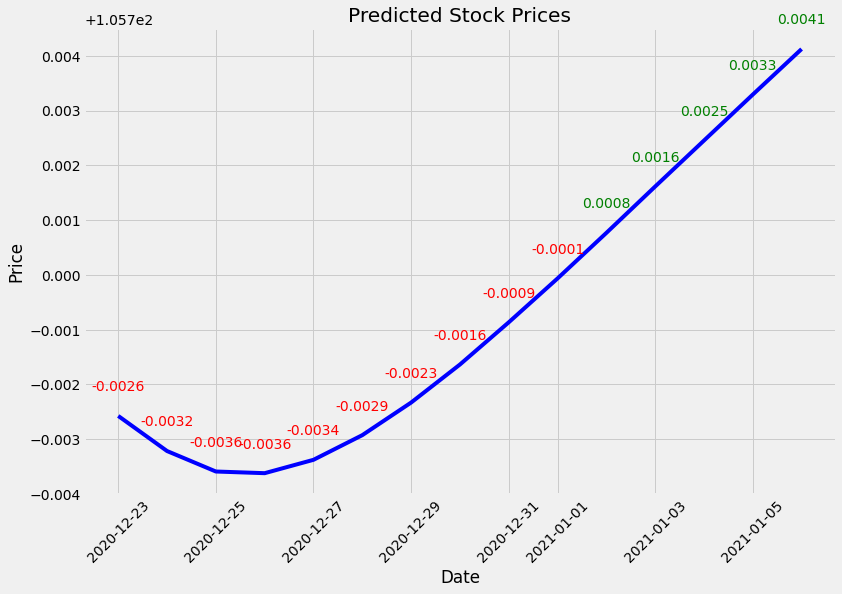

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(predicted_prices['Date'], predicted_prices['Price'], color='blue', label='Predicted Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Predicted Stock Prices')
ax.tick_params(axis='x', labelrotation=45)
for i, row in predicted_prices.iterrows():
    ax.text(row['Date'], row['Price'] + 0.000005*max(predicted_prices['Price']), format(row['Change'], '.4f'), ha='center', va='center', color='green' if row['Change'] > 0 else 'red')
plt.show()
